## Actividad Guaida I: La constante de Hubble

### Cuestión 4.1.

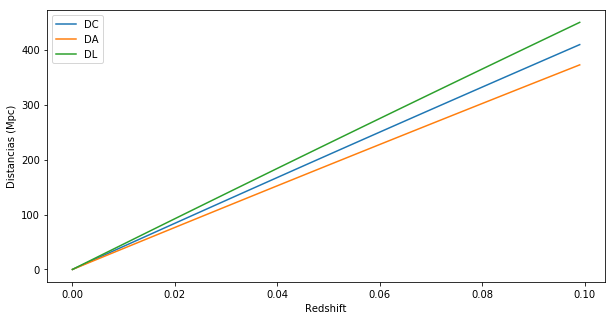

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Obtención de gráfica ocn la evolución de las distancias comóvil, angular y luminosidad según el redshift

data = pd.DataFrame([], columns=['z', 'DC', 'DA', 'DL'])

#Parámetros cosmológicos de WMAP
densidadr = 0
densidadm = 0.27
densidadk = 0
densidada = 0.73
h = 71

#Velocidad de la luz
c = 299792.458

def dc(z):
    return 1/(np.sqrt(densidadm*pow((1+z),3)+densidada))

dcAux = []
rangeData =  np.arange (0, 0.1, 0.001)

for z in rangeData:
    dcAux.append(c*quad(dc, 0, z)[0]/h)
    
data['DC'] = dcAux
data['DA'] = data.apply(lambda x : x['DC']/(1+z), axis=1)
data['DL'] = data.apply(lambda x : x['DC']*(1+z), axis=1)
    
plt.figure(figsize=(10,5))
plt.xlabel(u'Redshift')
plt.ylabel(u'Distancias (Mpc)')
plt.plot(rangeData, data['DC']) 
plt.plot(rangeData, data['DA'])    
plt.plot(rangeData, data['DL'])    
plt.legend()
plt.savefig('distancias1.png')
plt.show()


### Cuestión 4.2

In [49]:
import pandas as pd
from scipy.integrate import quad
import numpy as np

#Función para hallar las distancias angulares interpoladas según los datos proporcionados de WMAP5
def getDA(z):
    if(z is not ''):
        z = str(z)
        #Se obtiene y procesa la tabla de WMAP5
        data = pd.read_csv('table1_cosmoWMAP.txt', delimiter=r"\s+")
        new_header = data.iloc[0] 
        data = data[1:]
        data.columns = new_header
        data = data.dropna(axis=1,how='all')

        #Si está el valor exacto, se obiene su distancia angular
        if(len(data[data['z'] == z]) !=0):
            return float(data[data['z'] == z]['DA'])
        else:
            #Se obtiene el inmediatamente menor y mayor que el parámetro z
            menor = data[data['z'] < z].iloc[-1]
            mayor = data[data['z'] > z].iloc[0]

            x1 = float(menor['z'])
            y1 = float(menor['DA'])
            x2 = float(mayor['z'])
            y2 = float(mayor['DA'])

            return y1+(y2-y1)*(float(z)-x1)/(x2-x1)
        
#Función para hallar el tamaño de la galaxia según la distancia comóvil
def DAfromDC(data, fileName):
    
    finalData = pd.DataFrame([], columns=['z', 'DC', 'O', 'H0','d'])

    #Se calcula la distancia comóvil para cada galaxia en un rango de constantes de Hubble
    hList = [51,63,69,75,80,93,100]
    
    means = {}
    
    for h in hList:
        
        auxDF = pd.DataFrame(data, columns=['z', 'DC', 'O', 'H0', 'd'])

        auxDF['z'] = data['z']
        auxDF['O'] = data['deVRad_r']*2*2*np.pi/(360*3600) #diametro angular
        auxDF['H0'] = h

        #Parámetros cosmológicos de WMAP
        densidadr = 0
        densidadm = 0.27
        densidadk = 0
        densidada = 0.73
        
        #Velocidad de la luz https://www.um.es/docencia/barzana/FIS/Velocidad_luz.html)
        c = 299792.458

        def dc(z):
            return 1/(np.sqrt(densidadm*pow((1+z),3)+densidada))

        auxDF['DC'] = auxDF.apply(lambda x : (c*quad(dc, 0, x['z'])[0])/h, axis=1)
        auxDF['d'] = auxDF.apply(lambda x : ((x['DC']/(1+x['z']))*x['O'])*1000, axis=1)

        means[h] = np.mean(auxDF['d'])
        
        finalData = finalData.append(auxDF)
    
    #Se observa la evolución de la distancia según H0
    plt.figure(figsize=(10,5))
    plt.xlabel(u'Constante de Hubble (km/s/Mpc)')
    plt.ylabel(u'Tamaño físico medio de las galaxias (Kpc)')
    plt.bar(means.keys(), means.values())
    plt.savefig(fileName+'HUBBLE.png')
    plt.show()
    
    
#Función para hallar el rango de constantes de Hubble según los datos
def getHubbleRange(data):
    
    hubbleRange =  []

    #Parámetros cosmológicos de WMAP5
    densidadr = 0
    densidadm = 0.27
    densidadk = 0
    densidada = 0.73


    def dc(z):
        return 1/(np.sqrt(densidadm*pow((1+z),3)+densidada))

    hubbleRange = data.apply(lambda x : 71*np.sqrt(densidadm*pow((1+x['z']),3)+densidada), axis=1)

    print('EL rango de valores de la constante de Hubble va desde '+str(min(hubbleRange)) +" hasta "+str(max(hubbleRange)))

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

#Función para obtener la distancia de las galaxias de los cúmulos, las estadísticas y los histogramas
def processGalaxiesData(fileName, data):
    
    if(len(data) == 0):
        data = pd.read_csv(fileName+'.csv',skiprows=1)
    
    #Se crea una nueva columna para obtener la distancia angular
    data['DA'] = data.apply(lambda x : getDA(x['z']), axis=1)
    
    #Se crea una nueva columna para obtener el tamaño físico
    data['d'] = data.apply(lambda x : (x['DA']*1000*x['deVRad_r']*2*2*np.pi)/(360*3600), axis=1)
    
    #Se guarda el fichero con los datos
    data.to_excel(fileName+'.xlsx')
    
    #Se crea el histograma
    plt.figure(figsize=(10,5))
    plt.xlabel(u'Tamaño físico (Kpc)')
    plt.ylabel(u'Níúmero de galaxias')
    plt.hist(data['d'],alpha=0.5, histtype='bar', ec='white')    
    plt.savefig(fileName+'.png')
    plt.show()

    #Se obtienen las estadísticas 
    print(data.describe(include='all'))
    
    #Se analizan los tamaños
    DAfromDC(data, fileName)
    
    #Se obtienen los valores del rango de Hubble
    getHubbleRange(data)
    
    return data

#### VIRGO

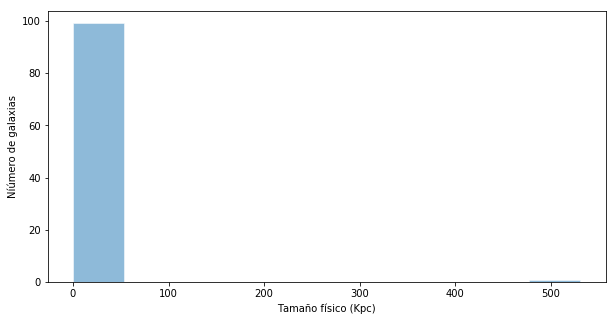

               ra         dec    deVRad_r           z           DA           d
count  100.000000  100.000000  100.000000  100.000000   100.000000  100.000000
mean   187.684062   12.643918   22.259054    0.003592    33.514246    8.716848
std      1.473302    0.938991   10.418624    0.002347   183.161745   52.794789
min    184.683138   11.435099    0.266152    0.000018     0.479409    0.001276
25%    186.520595   11.940300   15.919485    0.001757     7.685613    0.850273
50%    187.211351   12.418300   29.666225    0.003519    15.002537    3.291204
75%    188.873210   12.986001   29.671993    0.005295    23.378021    5.421164
max    190.781944   15.194389   29.681020    0.009433  1844.271570  530.638555


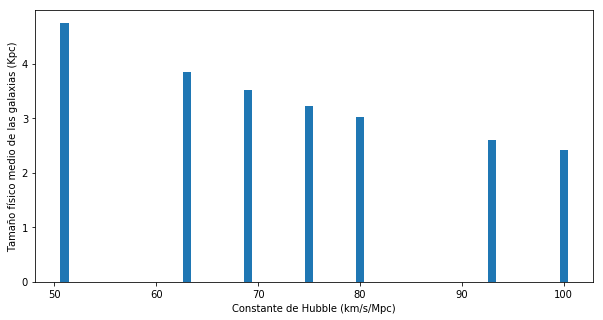

EL rango de valores de la constante de Hubble va desde 71.0005187028 hasta 71.2732955411


In [51]:
virgo = processGalaxiesData('VIRGO', '') #Detección de un outlier

C:\Users\Alexander\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Alexander\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


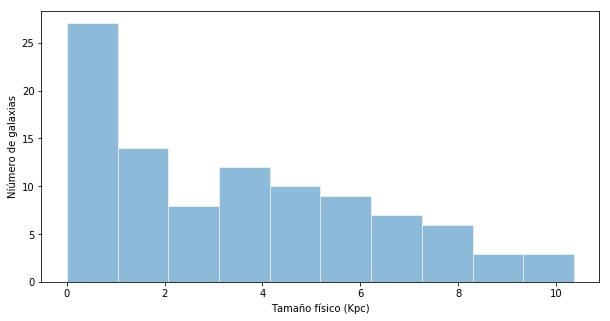

               ra        dec   deVRad_r          z         DA          d
count   99.000000  99.000000  99.000000  99.000000  99.000000  99.000000
mean   187.687240  12.645410  22.184161   0.003628  15.223768   3.444912
std      1.480455   0.943650  10.444555   0.002331   9.748123   2.835406
min    184.683138  11.435099   0.266152   0.000114   0.479409   0.001276
25%    186.519044  11.932521  15.691810   0.001814   7.642515   0.796014
50%    187.180452  12.385819  29.665600   0.003562  14.975207   3.257719
75%    188.882998  12.998034  29.671620   0.005386  22.595306   5.367120
max    190.781944  15.194389  29.681020   0.009433  39.386612  10.368989


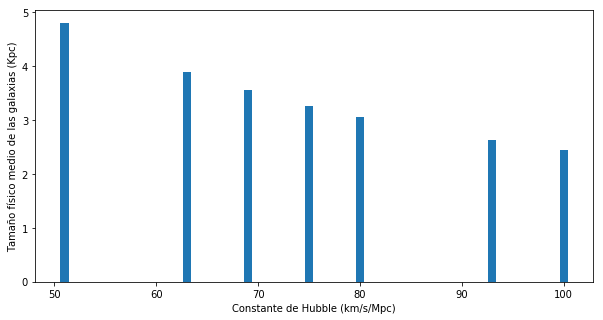

EL rango de valores de la constante de Hubble va desde 71.0032834183 hasta 71.2732955411


In [52]:
#Gráfica sin presunto outlier    
auxVirgo = virgo[virgo['z'] > 0.000019]
virgo = processGalaxiesData('VIRGO2', auxVirgo) #Detección de un outlier

#### COMA

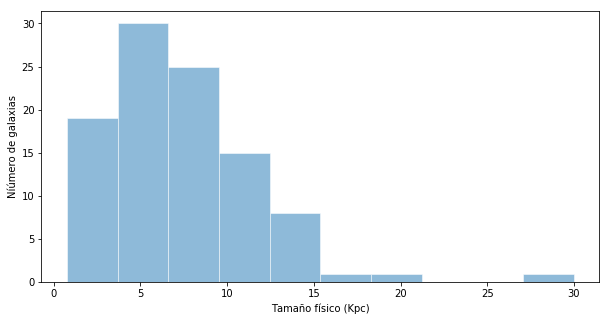

               ra         dec    deVRad_r           z          DA           d
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000
mean   194.924868   27.946422    7.878978    0.023296   95.624348    7.359570
std      0.279002    0.283033    4.400427    0.003146   12.572046    4.296223
min    194.374967   27.402569    0.915338    0.016552   68.523510    0.756192
25%    194.709619   27.738990    4.691498    0.020923   86.167888    4.158844
50%    194.950047   27.961076    7.096113    0.023598   96.876824    6.671744
75%    195.088346   28.097497    9.891261    0.025675  105.141968    9.641742
max    195.632822   28.551365   29.675960    0.029591  120.625402   30.008178


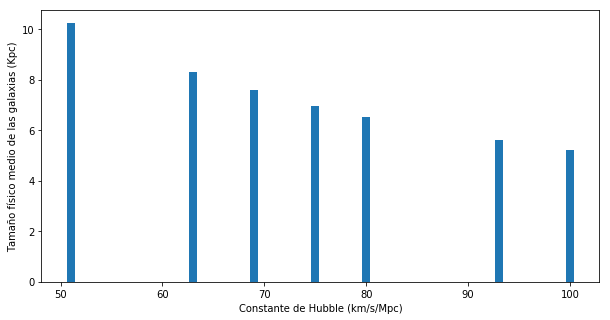

EL rango de valores de la constante de Hubble va desde 71.4822494913 hasta 71.8709770094


In [53]:
coma = processGalaxiesData('COMA', '')

#### ABELL85

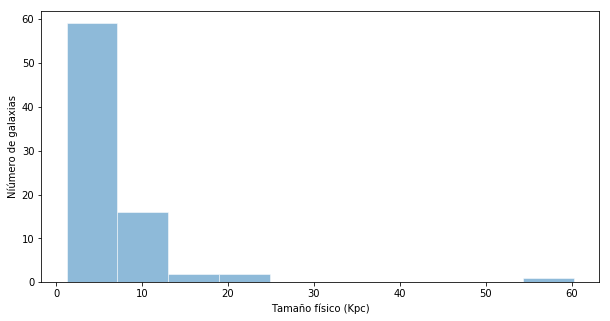

              ra        dec   deVRad_r          z          DA          d
count  80.000000  80.000000  80.000000  80.000000   80.000000  80.000000
mean   10.453589  -9.316733   3.156954   0.055608  219.860408   6.684605
std     0.103167   0.127667   3.519233   0.002780   10.294459   7.174105
min    10.210066  -9.548193   0.577256   0.049117  195.693962   1.227165
25%    10.386403  -9.426307   1.841920   0.053819  213.256900   3.967362
50%    10.448564  -9.326103   2.638120   0.055580  219.788283   5.486874
75%    10.523381  -9.208257   3.368017   0.057463  226.743011   7.207055
max    10.667729  -9.042990  29.672770   0.061044  239.871842  60.270800


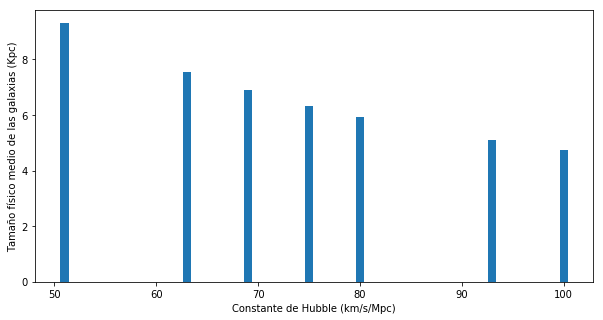

EL rango de valores de la constante de Hubble va desde 72.4677087238 hasta 72.8407804403


In [54]:
abell = processGalaxiesData('ABELL85', '')

#### GALAXIAS DE CAMPO

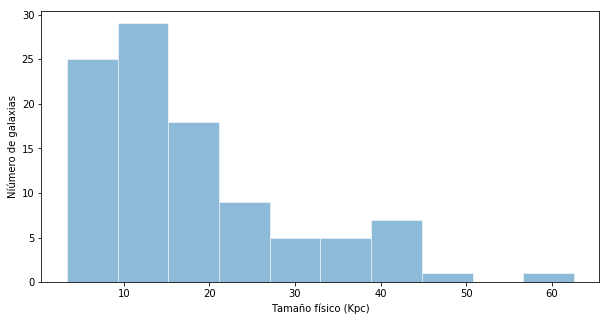

               ra         dec    deVRad_r           z           DA           d
count  100.000000  100.000000  100.000000  100.000000   100.000000  100.000000
mean   125.796398   54.928182    3.571550    0.163144   557.450602   17.815578
std      0.918136    0.349679    2.645985    0.070318   177.118564   11.697971
min    124.472505   54.359415    0.434385    0.100535   377.683365    3.350942
25%    124.886610   54.666314    1.622439    0.118030   434.813389    9.293567
50%    125.746095   54.857535    2.375834    0.139037   500.435598   13.616186
75%    126.724065   55.238063    4.974428    0.181209   623.037568   23.766614
max    127.312452   55.640702   12.320030    0.431922  1154.469693   62.608079


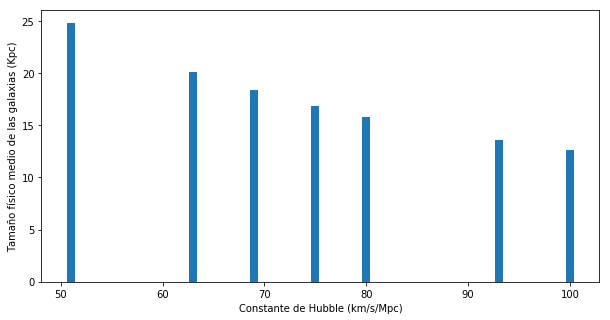

EL rango de valores de la constante de Hubble va desde 74.1225925194 hasta 87.6130759041


In [55]:
campo = processGalaxiesData('GALAXIAS_CAMPO', '')

#### GLOBAL

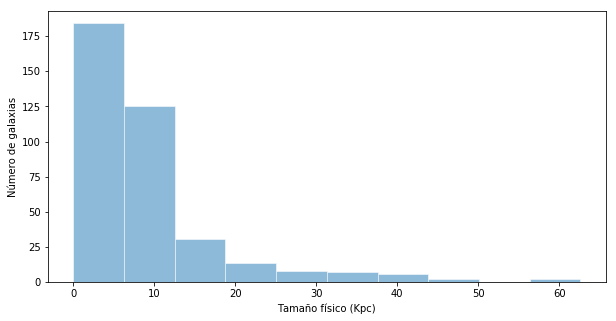

               ra         dec    deVRad_r           z           DA           d
count  379.000000  379.000000  379.000000  379.000000   379.000000  379.000000
mean   135.856070   23.203212    9.482430    0.061878   222.700477    8.953376
std     70.586393   22.924119    9.920744    0.072831   231.294470    9.165177
min     10.210066   -9.548193    0.266152    0.000114     0.479409    0.001276
25%    124.696010   11.747285    2.375834    0.008022    33.547189    3.686176
50%    186.198171   27.581350    5.068646    0.027234   111.322282    6.573180
75%    194.471802   54.415942   12.288490    0.105584   394.407055   10.402276
max    195.632822   55.640702   29.681020    0.431922  1154.469693   62.608079


In [56]:
#Análisis en conjunto
main = virgo
main = main.append(coma)
main = main.append(abell)
main = main.append(campo)

#Se crea el histograma
plt.figure(figsize=(10,5))
plt.xlabel(u'Tamaño físico (Kpc)')
plt.ylabel(u'Número de galaxias')
plt.hist(main['d'],alpha=0.5, histtype='bar', ec='white')    
plt.savefig('main.png')
plt.show()

main = virgo
main = main.append(coma)
main = main.append(abell)
main = main.append(campo)

#Se obtienen las estadísticas 
print(main.describe(include='all'))